# FastMRI 데이터 풀 분석
**train / val / leaderboard × brain / knee × acc4 / acc8**


경로 구조  
* train, val : `split/{image,kspace}/*.h5`  
* leaderboard : `leaderboard/acc{4,8}/{image,kspace}/*.h5`

이 노트북은  
*Pixel 도메인·k-space 도메인·스캔 지오메트리·노이즈/아티팩트*  
를 한 번에 훑어보도록 구성했습니다. 셀을 순서대로 실행하면 주요 분포와 차이를 시각적으로 확인할 수 있습니다.


1. 공통 import & 유틸 (Code 셀)

In [1]:
import os, re, glob, json, warnings
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import h5py
from skimage.metrics import structural_similarity as ssim
from tqdm.auto import tqdm   # tqdm 없으면 경고만, 동작에는 영향 X
warnings.filterwarnings("ignore", category=RuntimeWarning)

plt.rcParams['figure.dpi'] = 120

# ===== 경로 설정 =====
Data_dir = "/home/swpants05/Desktop/2025_FastMri/Data"   # <-- 본인 경로로 수정

# ===== 파일 탐색 RegExp =====
REG = re.compile(r"(brain|knee)_acc([48])_(\d+)\.h5")

def list_files(split:str, dtype:str):
    """
    split : train / val / leaderboard
    dtype : image / kspace
    """
    patterns = []
    if split in ("train", "val"):
        # ex) Data/train/image/*.h5
        patterns.append(os.path.join(Data_dir, split, dtype, "*.h5"))
    elif split == "leaderboard":
        # ex) Data/leaderboard/acc4/image/*.h5  ,  Data/leaderboard/acc8/kspace/*.h5
        patterns.append(os.path.join(Data_dir, split, "acc*", dtype, "*.h5"))
    else:
        raise ValueError(split)

    paths = []
    for pat in patterns:
        paths.extend(glob.glob(pat))
    return sorted(paths)

# 인덱스 딕셔너리 만들기
files = {
    split:{dtype:list_files(split, dtype)
           for dtype in ("image","kspace")
           if list_files(split,dtype)}
    for split in ("train","val","leaderboard")
}

print("파일 개수 요약")
print(json.dumps({k:{t:len(v) for t,v in d.items()} for k,d in files.items()}, indent=2))


파일 개수 요약
{
  "train": {
    "image": 340,
    "kspace": 340
  },
  "val": {
    "image": 60,
    "kspace": 60
  },
  "leaderboard": {
    "image": 116,
    "kspace": 116
  }
}


2. 헬퍼 함수 (Code 셀)

In [2]:
import cv2, math
def load_mask(h5_path):
    with h5py.File(h5_path,'r') as f:
        return f['mask'][()].astype(bool) if 'mask' in f else None

def accel(mask):
    return round(len(mask)/mask.sum(), 2) if mask is not None else np.nan

def center_energy_ratio(kspace, pct=0.05):
    _,_,_,W = kspace.shape
    c = int(W*pct/2)
    center = kspace[..., W//2-c:W//2+c]
    return np.abs(center).sum()/np.abs(kspace).sum()

def rss(img, axis=0):
    return np.sqrt((np.abs(img)**2).sum(axis=axis))

def quick_ifft2(kc):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kc, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))

def est_noise_sigma(img, pct_bg=0.1):
    thresh = np.percentile(img, pct_bg*100)
    return img[img<thresh].std()

def psnr(img, ref):
    mse = ((img-ref)**2).mean()
    return 20*math.log10(ref.max()) - 10*math.log10(mse) if mse>0 else np.inf

def get_attrs(h5_path):
    with h5py.File(h5_path,'r') as f:
        return {k:v for k,v in f.attrs.items()}


3. k-space 마스크 & 배속 분포 (Code 셀)

train-mask:   0%|          | 0/340 [00:00<?, ?it/s]

val-mask:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard-mask:   0%|          | 0/116 [00:00<?, ?it/s]

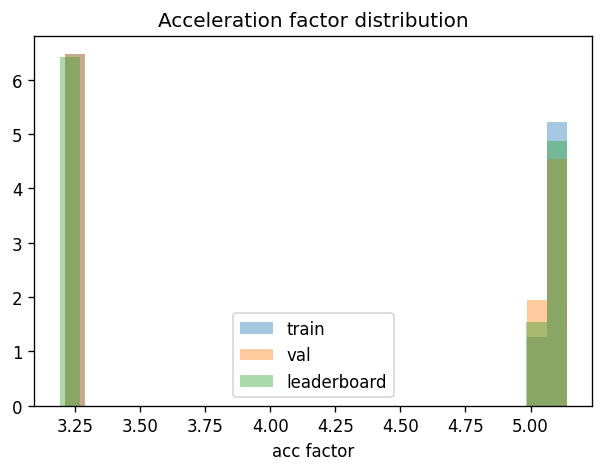

In [4]:
# ===== 3. k-space 마스크 & 배속 분포 =====
LB_REG = re.compile(r"(brain|knee)_test(\d+)\.h5")  # leaderboard 전용

mask_stats = []

for split in ("train", "val", "leaderboard"):
    for ks_path in tqdm(files[split].get("kspace", []), desc=f"{split}-mask"):
        m = load_mask(ks_path)
        if m is None:              # 일부 leaderboard 파일엔 mask 없을 수 있음
            continue

        fname = os.path.basename(ks_path)
        m_acc = "4" if "/acc4/" in ks_path else ("8" if "/acc8/" in ks_path else None)

        # ① train/val 패턴 → brain_acc4_1.h5
        mm = REG.search(fname)
        if mm:
            body, acc, idx = mm.groups()

        # ② leaderboard 패턴 → brain_test10.h5
        else:
            mm = LB_REG.search(fname)
            if not mm:
                print("❗️ SKIP (unknown name pattern):", ks_path)
                continue
            body, idx = mm.groups()
            acc = m_acc if m_acc is not None else "?"

        mask_stats.append({
            "split":  split,
            "body":   body,
            "acc":    acc,
            "id":     idx,
            "accel":  accel(m),
            "mask":   m
        })

# -------- 히스토그램 --------
plt.figure(figsize=(6,4))
for split, col in zip(("train","val","leaderboard"), ('C0','C1','C2')):
    vals = [d["accel"] for d in mask_stats if d["split"] == split]
    if vals:
        plt.hist(vals, bins=25, alpha=.4, label=split, density=True, color=col)
plt.title("Acceleration factor distribution"); plt.xlabel("acc factor"); plt.legend(); plt.show()


4. 마스크 패턴 heatmap (brain-acc4 예시) (Code 셀)

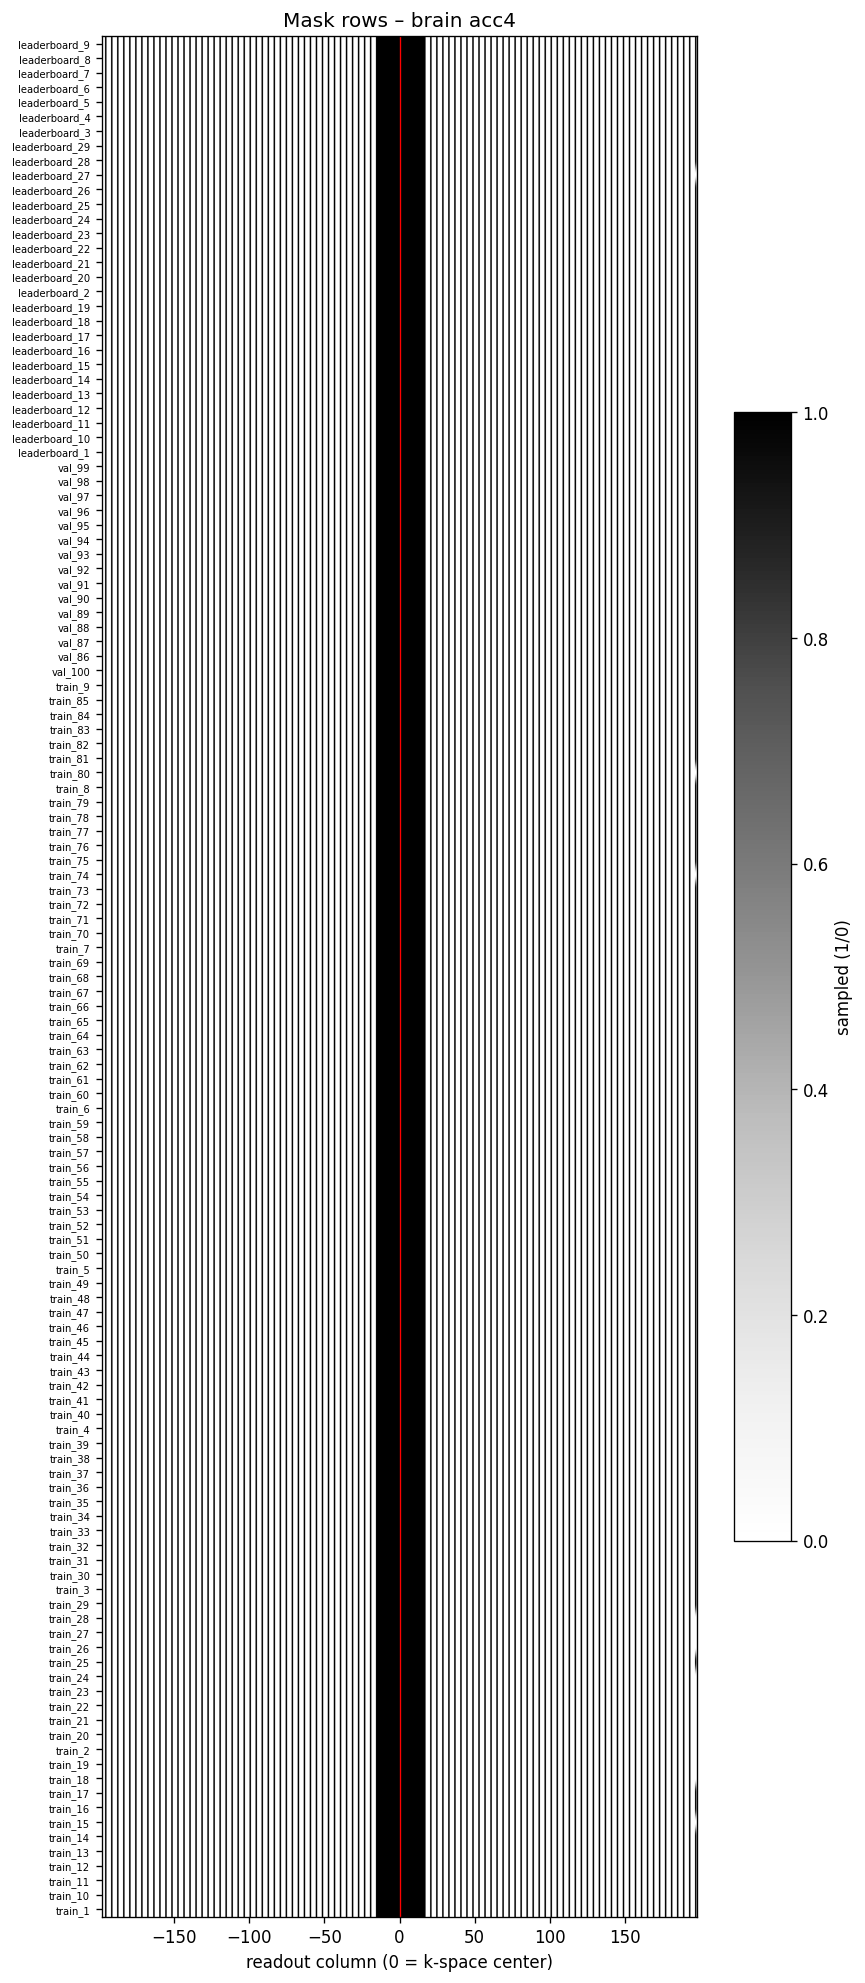

In [11]:
def plot_mask_matrix(body="brain", acc="4"):
    """
    k-space 중심(컬럼 mid)을 모두 같은 열에 맞춘 뒤 heatmap 출력.
    좌/우는 0 패딩.
    """
    mats, labels, mids, widths = [], [], [], []

    # 1) 수집
    for d in mask_stats:
        if d["body"] == body and d["acc"] == acc:
            m = d["mask"].astype(int)
            mats.append(m)
            widths.append(len(m))
            mids.append(len(m)//2)           # 중앙 인덱스
            labels.append(f'{d["split"]}_{d["id"]}')

    if not mats:
        print("해당 조합 없음"); return

    # 2) 공통 캔버스 폭 결정
    max_w   = max(widths)
    pivot   = max_w // 2                 # 모두가 맞출 '중앙 열' 위치
    canvasW = max_w                      # 출력 폭 (==가장 긴 마스크 폭)

    # 3) 패딩으로 맞추기
    mats_pad = []
    for m, mid in zip(mats, mids):
        left_pad  = pivot - mid
        right_pad = canvasW - left_pad - len(m)
        mats_pad.append(np.pad(m, (left_pad, right_pad)))
    mats_pad = np.stack(mats_pad)

    # 4) 플롯
    h = max(4, 0.15 * len(labels) + 1)   # 충분히 긴 캔버스
    plt.figure(figsize=(8, h))
    # extent 를 음/양 축으로 바꿔 중앙 = 0
    plt.imshow(mats_pad, aspect='auto', cmap='Greys',
               extent=[-pivot, canvasW - pivot, 0, len(labels)])
    plt.axvline(0, color='red', lw=0.8)                  # 중앙선 표시
    plt.yticks(np.arange(len(labels)) + 0.5, labels, fontsize=6)
    plt.xlabel("readout column (0 = k-space center)")
    plt.title(f"Mask rows – {body} acc{acc}")
    plt.colorbar(label='sampled (1/0)', shrink=0.6)
    plt.show()



plot_mask_matrix("brain","4")

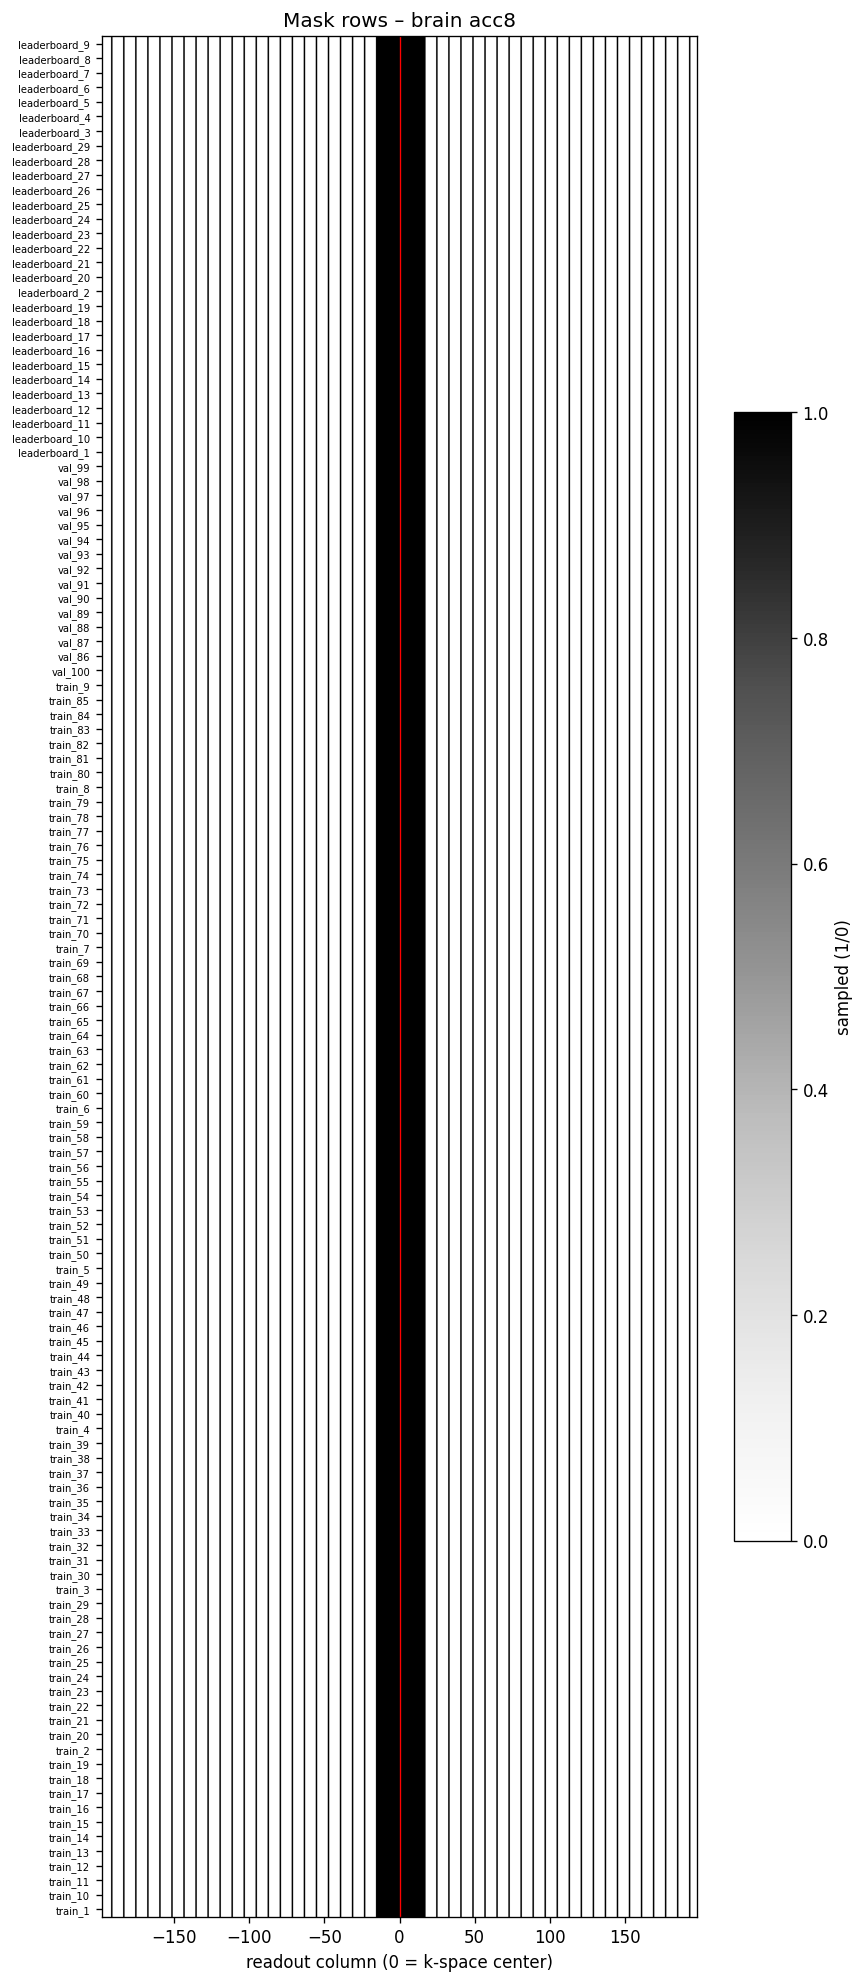

In [12]:
plot_mask_matrix("brain","8")

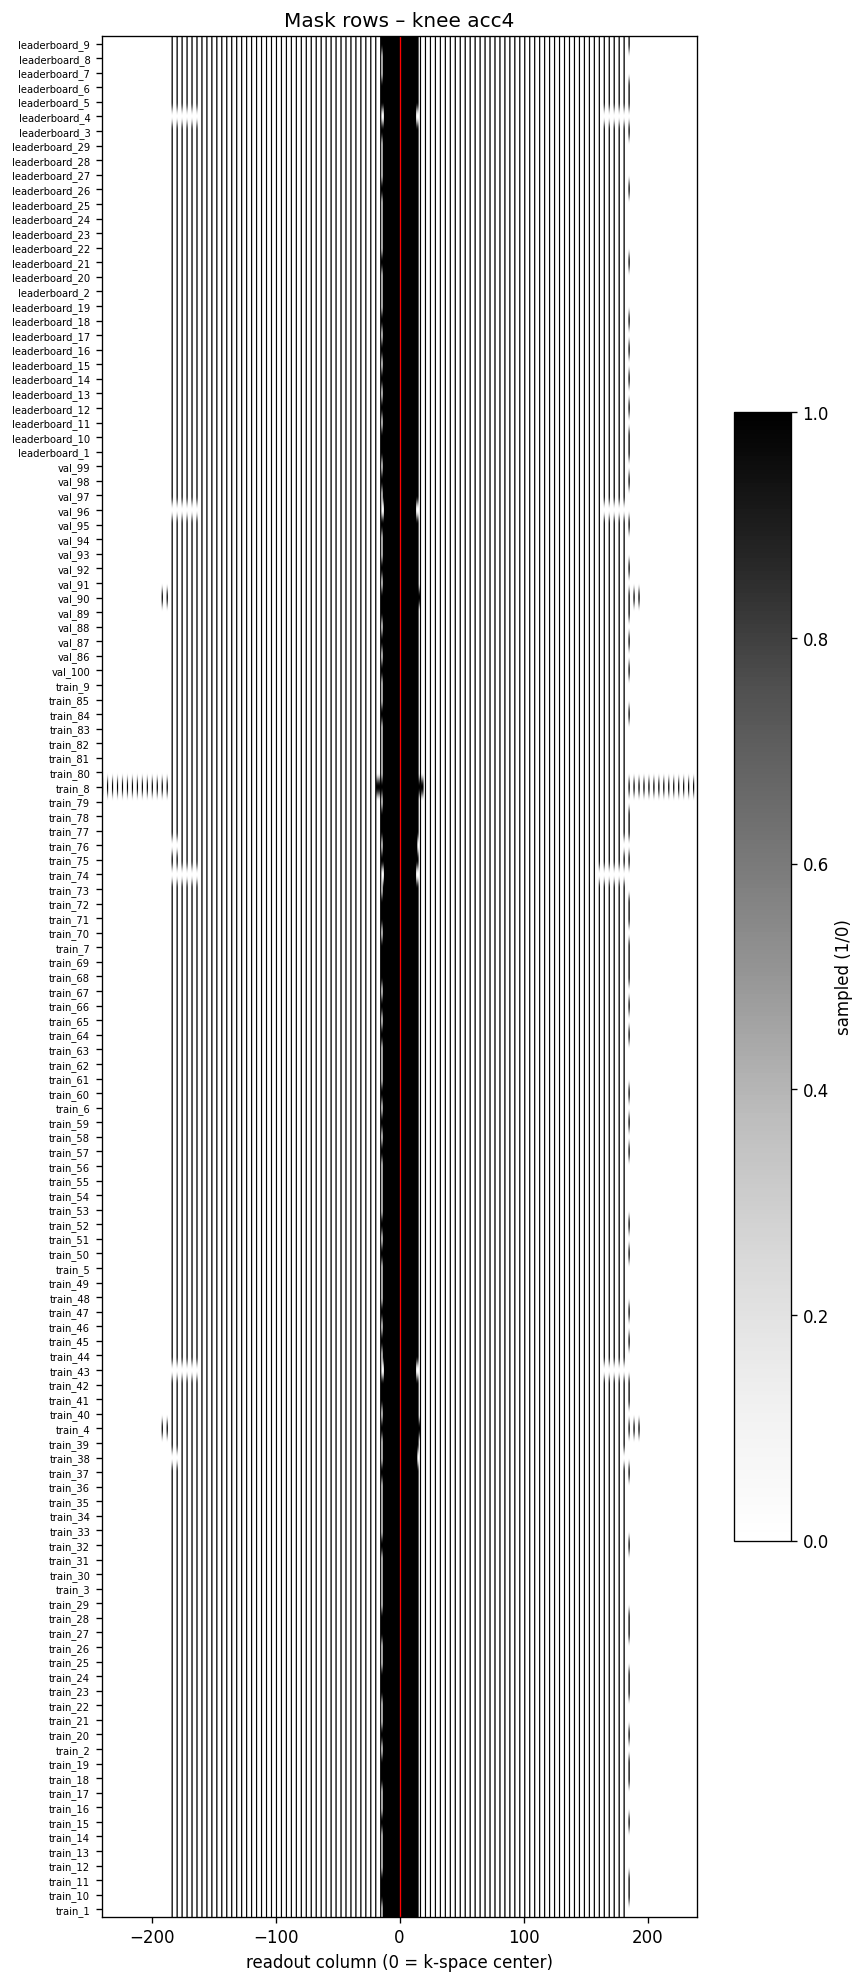

In [13]:
plot_mask_matrix("knee","4")

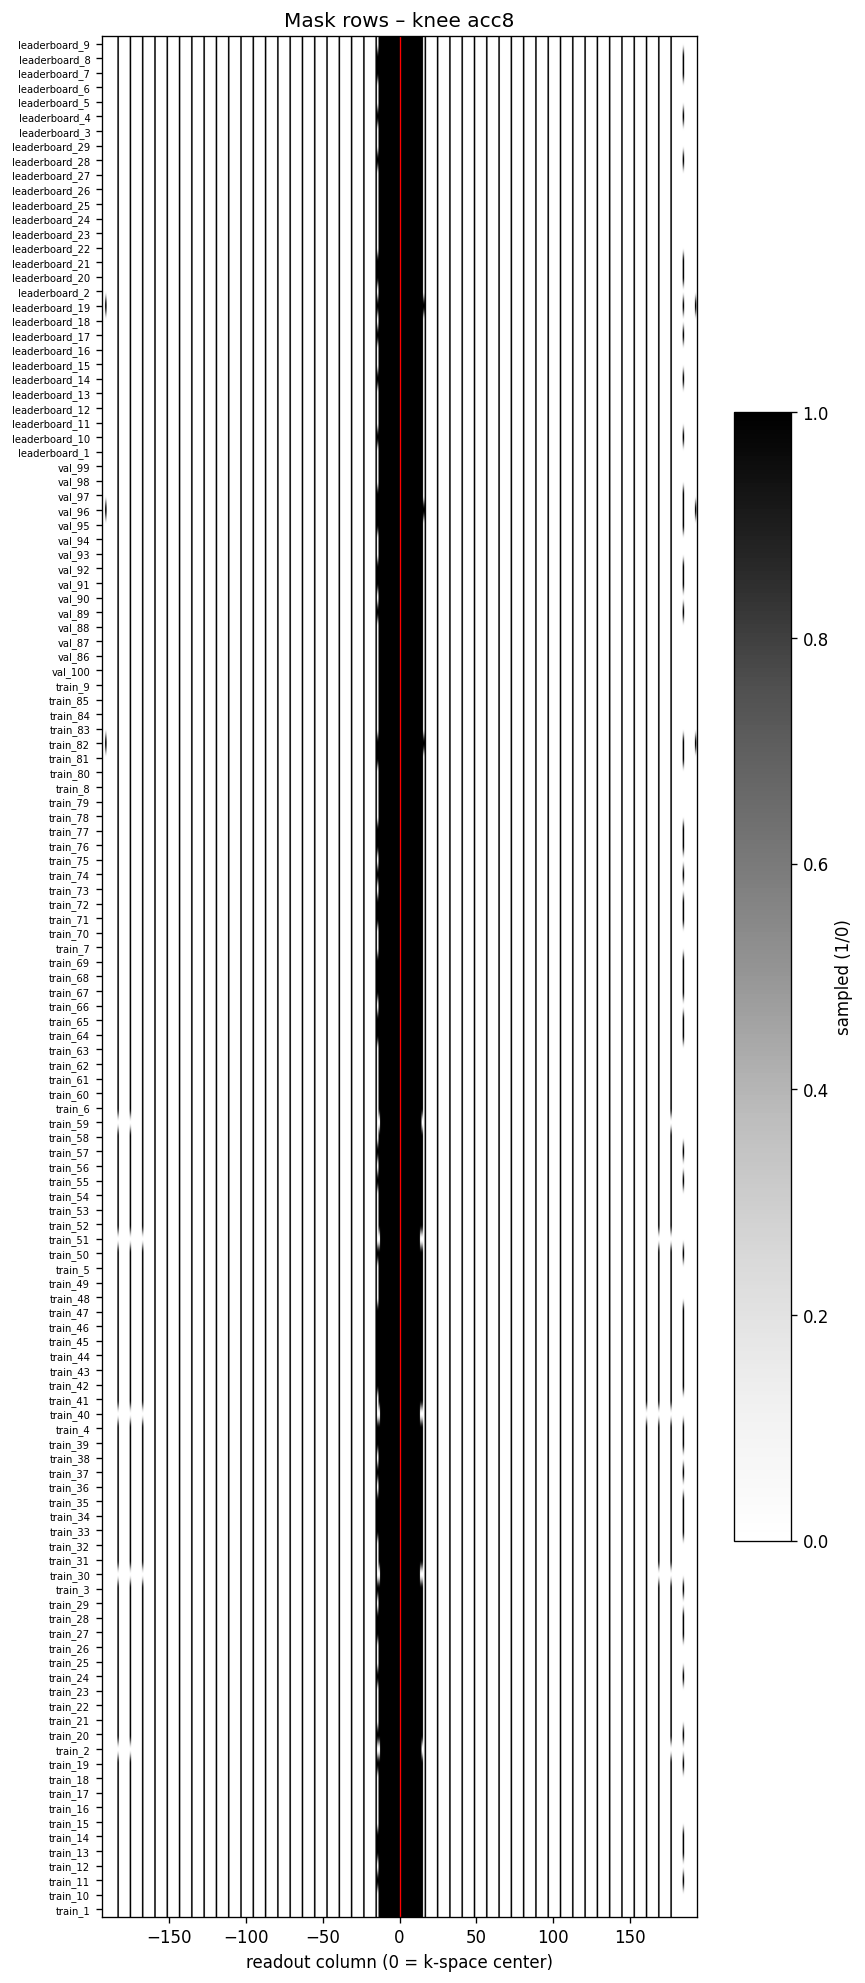

In [14]:
plot_mask_matrix("knee","8")

5. k-space 중심 에너지 / 노이즈 통계 (Code 셀)

train-energy:   0%|          | 0/340 [00:00<?, ?it/s]

val-energy:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard-energy:   0%|          | 0/116 [00:00<?, ?it/s]

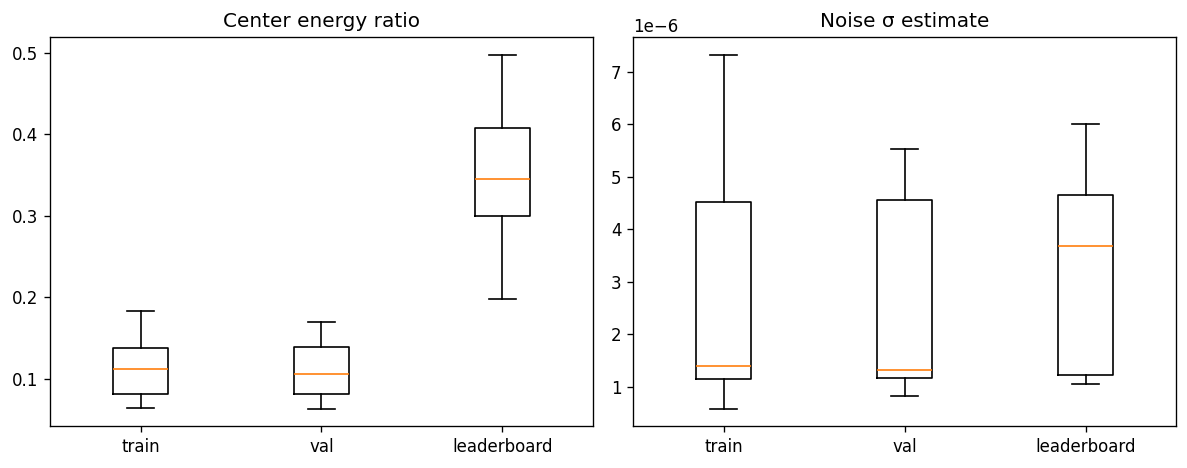

In [19]:
# ===== 5-B. 중심 에너지 & 노이즈 통계 (클린) =====
energy, noise = defaultdict(list), defaultdict(list)

for split in ("train", "val", "leaderboard"):
    img_list = files[split].get("image", [])
    ks_list  = files[split].get("kspace", [])

    for img_path, ks_path in tqdm(zip(img_list, ks_list),
                                  total=min(len(img_list), len(ks_list)),
                                  desc=f"{split}-energy"):

        # ---- center energy (앞 4 slice) ----
        with h5py.File(ks_path, "r") as f:
            kc = f["kspace"][:4]
        energy[split].append(center_energy_ratio(kc))

        # ---- noise σ ----
        with h5py.File(img_path, "r") as f:
            if "image_label" in f:
                ref = f["image_label"][0]
            elif "label" in f:
                ref = f["label"][0]
            elif "image_grappa" in f:
                ref = f["image_grappa"][0]
            else:
                continue
        noise[split].append(est_noise_sigma(ref))

# --- NaN & tiny value 필터링 ---
CLEAN_NOISE = {}
for s, arr in noise.items():
    clean = [x for x in arr if np.isfinite(x) and x > 1e-10]
    CLEAN_NOISE[s] = clean

# --- boxplot 데이터 준비 ---
order = ("train", "val", "leaderboard")
energy_data = [energy[s]      for s in order if energy[s]]
energy_lbls = [s              for s in order if energy[s]]
noise_data  = [CLEAN_NOISE[s] for s in order if CLEAN_NOISE[s]]
noise_lbls  = [s              for s in order if CLEAN_NOISE[s]]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].boxplot(energy_data, tick_labels=energy_lbls)
ax[0].set_title("Center energy ratio")

if noise_data:
    ax[1].boxplot(noise_data, tick_labels=noise_lbls)
else:
    ax[1].text(0.5, 0.5, "No valid noise data", ha="center",
               va="center", fontsize=12)
ax[1].set_title("Noise σ estimate")

plt.tight_layout()
plt.show()


train-energy:   0%|          | 0/340 [00:00<?, ?it/s]

val-energy:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard-energy:   0%|          | 0/116 [00:00<?, ?it/s]

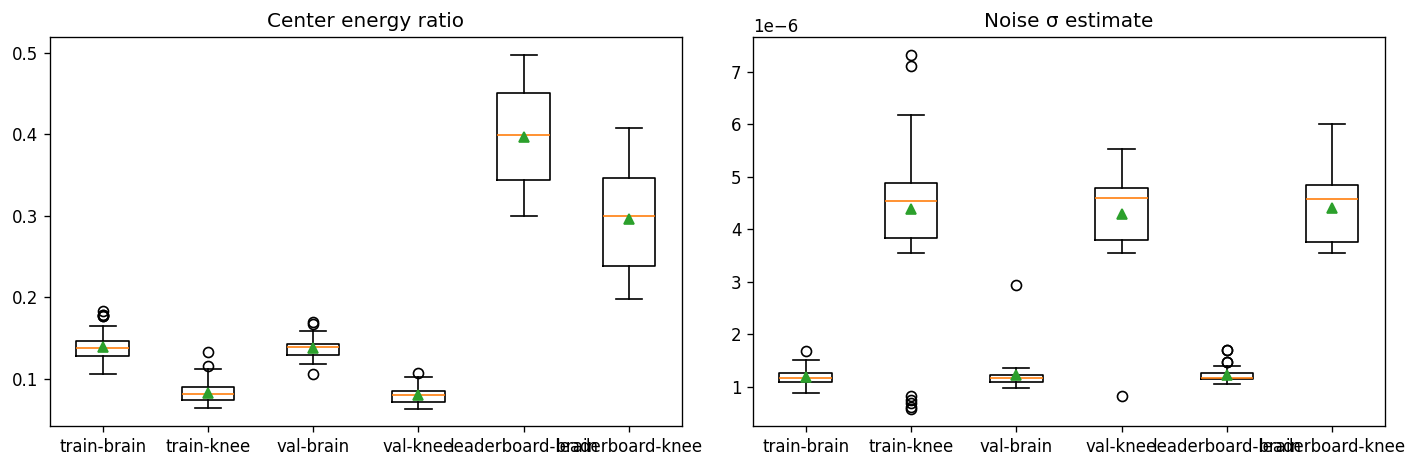

In [25]:
# ===== 5C. 중심 에너지 & 노이즈 σ (brain / knee 분리) =====
energy, noise = defaultdict(list), defaultdict(list)   # key: (split, body)

for split in ("train", "val", "leaderboard"):
    img_list = files[split].get("image", [])
    ks_list  = files[split].get("kspace", [])

    for img_path, ks_path in tqdm(zip(img_list, ks_list),
                                  total=min(len(img_list), len(ks_list)),
                                  desc=f"{split}-energy"):

        body = "brain" if "brain_" in os.path.basename(img_path) else "knee"

        # ---- center energy ----
        with h5py.File(ks_path, "r") as f:
            kc = f["kspace"][:4]
        energy[(split, body)].append(center_energy_ratio(kc))

        # ---- noise σ ----
        with h5py.File(img_path, "r") as f:
            if "image_label" in f:
                ref = f["image_label"][0]
            elif "label" in f:
                ref = f["label"][0]
            elif "image_grappa" in f:
                ref = f["image_grappa"][0]
            else:
                continue
        noise[(split, body)].append(est_noise_sigma(ref))

# NaN / tiny 필터
clean_noise = {k:[x for x in v if np.isfinite(x) and x>1e-10] for k,v in noise.items()}

labels6 = [(s,b) for s in ("train","val","leaderboard") for b in ("brain","knee")]
lab_txt = [f"{s}-{b}" for s,b in labels6]

ener_data = [energy[k]      for k in labels6]
noise_data= [clean_noise[k] for k in labels6]

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].boxplot(ener_data, tick_labels=lab_txt, showmeans=True)
ax[0].set_title("Center energy ratio")

ax[1].boxplot(noise_data, tick_labels=lab_txt, showmeans=True)
ax[1].set_title("Noise σ estimate")

plt.tight_layout(); plt.show()


6. 이미지 도메인: 픽셀 mean/var + Gradient Histogram (Code 셀)

train-pixel:   0%|          | 0/340 [00:00<?, ?it/s]

val-pixel:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard-pixel:   0%|          | 0/116 [00:00<?, ?it/s]

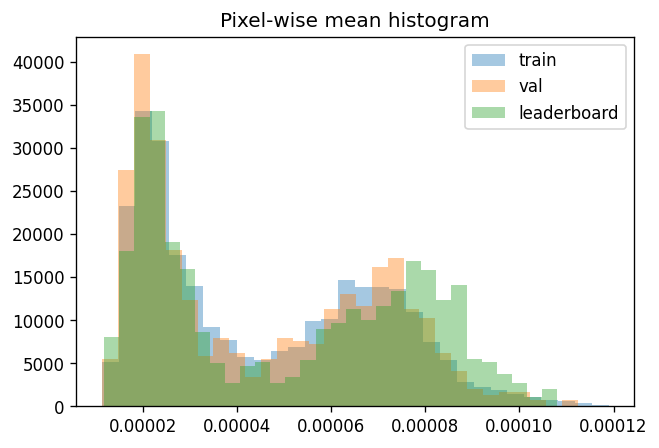

In [20]:
sobel = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])

pix_mean, pix_var, grad_mag = defaultdict(list), defaultdict(list), defaultdict(list)

for split in ("train","val","leaderboard"):
    for img_path in tqdm(files[split]["image"], desc=f"{split}-pixel"):
        with h5py.File(img_path,'r') as f:
            key = 'image_label' if 'image_label' in f else 'image_grappa'
            vol = f[key][:]           # (slices,H,W)
        pix_mean[split].extend(vol.mean(axis=(1,2)))
        pix_var[split].extend(vol.var(axis=(1,2)))

        g = np.abs(cv2.filter2D(vol[0],-1,sobel))+np.abs(cv2.filter2D(vol[0],-1,sobel.T))
        grad_mag[split].append(g.mean())

# ---- 시각화 ----
plt.figure(figsize=(6,4))
for s,c in zip(pix_mean, ('C0','C1','C2')):
    plt.hist(pix_mean[s], bins=30, alpha=.4, label=s, density=True, color=c)
plt.title("Pixel-wise mean histogram"); plt.legend(); plt.show()


train-pixel:   0%|          | 0/340 [00:00<?, ?it/s]

val-pixel:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard-pixel:   0%|          | 0/116 [00:00<?, ?it/s]

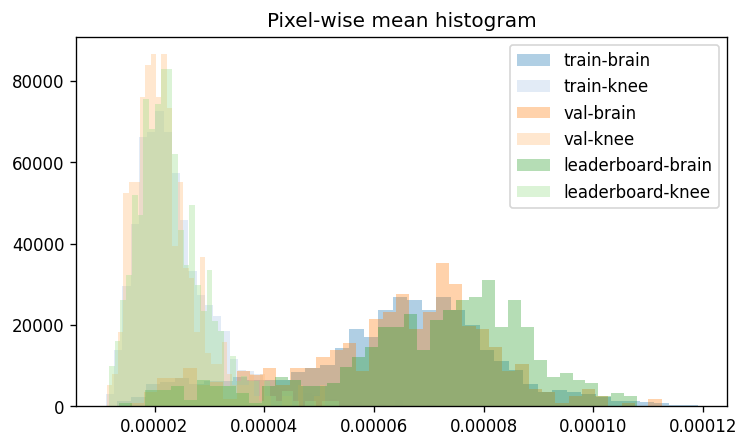

In [26]:
sobel = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])

pix_mean, pix_var = defaultdict(list), defaultdict(list)

for split in ("train","val","leaderboard"):
    for img_path in tqdm(files[split]["image"], desc=f"{split}-pixel"):
        body = "brain" if "brain_" in os.path.basename(img_path) else "knee"
        with h5py.File(img_path,'r') as f:
            key = 'image_label' if 'image_label' in f else 'image_grappa'
            vol = f[key][:]

        pix_mean[(split,body)].extend(vol.mean(axis=(1,2)))
        pix_var[(split,body)].extend(vol.var(axis=(1,2)))

# mean 히스토그램
plt.figure(figsize=(7,4))
for (s,b),col in zip(pix_mean, plt.cm.tab20.colors):
    plt.hist(pix_mean[(s,b)], bins=40, alpha=.35, density=True,
             label=f"{s}-{b}", color=col)
plt.title("Pixel-wise mean histogram"); plt.legend(); plt.show()


7. GRAPPA vs Label SSIM / PSNR (Code 셀)

train-ssim:   0%|          | 0/340 [00:00<?, ?it/s]

val-ssim:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard-ssim:   0%|          | 0/116 [00:00<?, ?it/s]

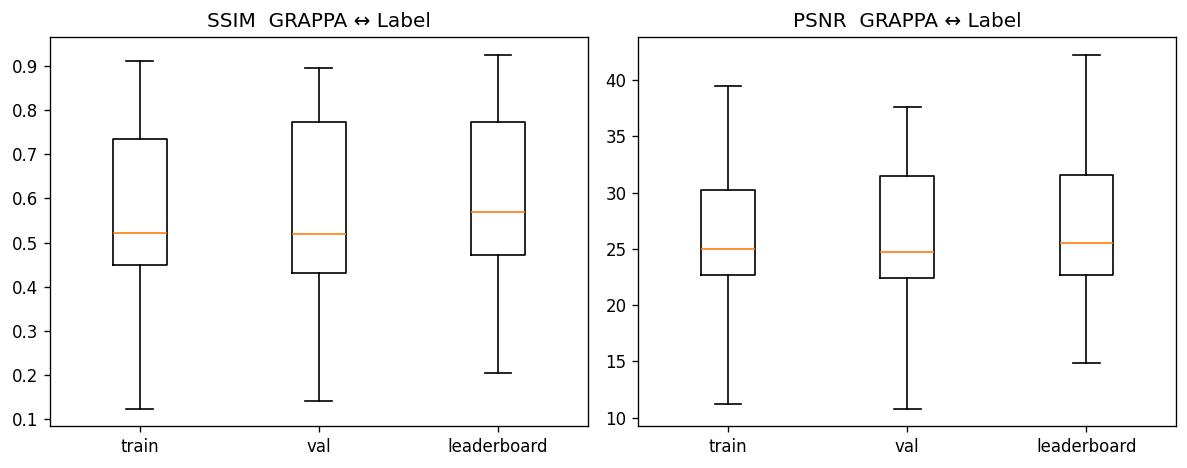

In [22]:
# ===== GRAPPA vs Label  SSIM / PSNR  (train + val + leaderboard) =====
ssim_stat, psnr_stat = defaultdict(list), defaultdict(list)

for split in ("train", "val", "leaderboard"):
    for img_path in tqdm(files[split]["image"], desc=f"{split}-ssim"):
        with h5py.File(img_path, "r") as f:
            # 일부 파일은 label 이 없을 수도 있으니 검사
            if "image_label" not in f:
                continue
            lab = f["image_label"][:]          # (slices, H, W)
            grp = f["image_grappa"][:]

        for g, l in zip(grp, lab):
            ssim_stat[split].append(
                ssim(g, l, data_range=l.max() - l.min())
            )
            psnr_stat[split].append(psnr(g, l))

# --- 그래프 ---
order = ("train", "val", "leaderboard")
ssim_data = [ssim_stat[s] for s in order]
psnr_data = [psnr_stat[s] for s in order]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].boxplot(ssim_data, tick_labels=order)
ax[0].set_title("SSIM  GRAPPA ↔ Label")

ax[1].boxplot(psnr_data, tick_labels=order)
ax[1].set_title("PSNR  GRAPPA ↔ Label")

plt.tight_layout()
plt.show()


train-ssim:   0%|          | 0/340 [00:00<?, ?it/s]

val-ssim:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard-ssim:   0%|          | 0/116 [00:00<?, ?it/s]

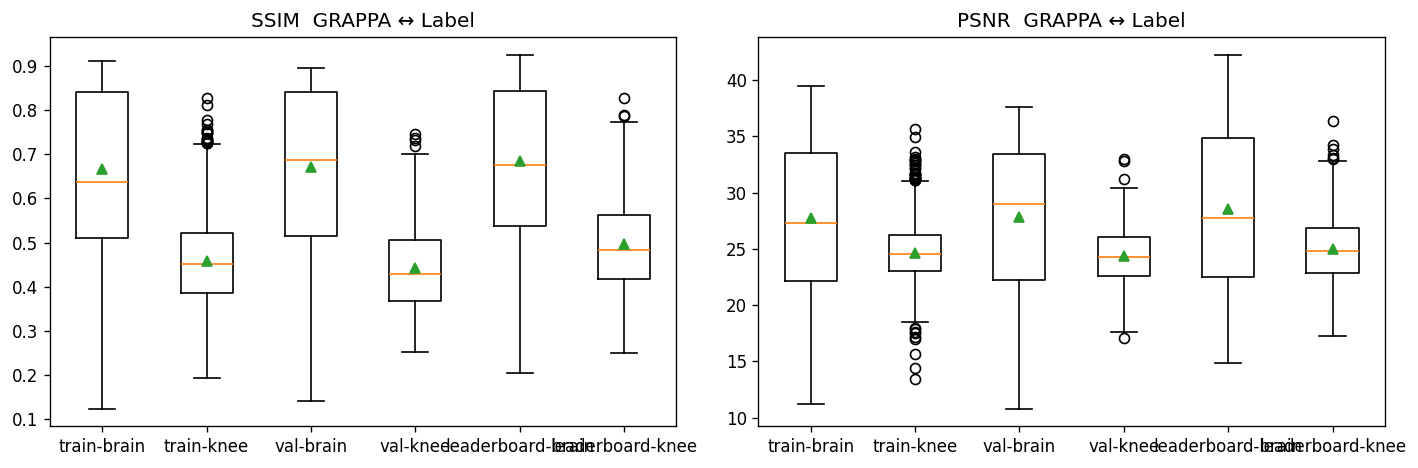

In [30]:
# ===== GRAPPA ↔ Label  SSIM / PSNR  (train + val + leaderboard, brain/knee 분리) =====
ssim_stat, psnr_stat = defaultdict(list), defaultdict(list)

for split in ("train","val","leaderboard"):
    for img_path in tqdm(files[split]["image"], desc=f"{split}-ssim"):
        body = "brain" if "brain_" in os.path.basename(img_path) else "knee"
        with h5py.File(img_path,'r') as f:
            if "image_label" not in f:
                continue
            lab = f["image_label"][:]     # (slices, H, W)
            grp = f["image_grappa"][:]

        for g, l in zip(grp, lab):
            # np.ptp(l) = l.max() - l.min()
            ssim_stat[(split,body)].append(
                ssim(g, l, data_range=np.ptp(l))
            )
            psnr_stat[(split,body)].append(psnr(g, l))

# 시각화 준비
labels6  = [(s,b) for s in ("train","val","leaderboard") for b in ("brain","knee")]
lab_text = [f"{s}-{b}" for s,b in labels6]
ssim_data= [ssim_stat[k] for k in labels6]
psnr_data= [psnr_stat[k] for k in labels6]

# 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].boxplot(ssim_data, tick_labels=lab_text, showmeans=True)
ax[0].set_title("SSIM  GRAPPA ↔ Label")

ax[1].boxplot(psnr_data, tick_labels=lab_text, showmeans=True)
ax[1].set_title("PSNR  GRAPPA ↔ Label")

plt.tight_layout()
plt.show()


8. 스캔 메타데이터(있다면) 요약 (Code 셀)

In [23]:
meta = defaultdict(lambda: defaultdict(list))
for split in ("train","val","leaderboard"):
    for img_path in files[split]["image"]:
        attrs = get_attrs(img_path)
        for k,v in attrs.items():
            meta[split][k].append(v)

for k in sorted(meta["train"]):
    print(f"--- {k} ---")
    for split in meta:
        vals = meta[split][k]
        if vals:
            uniq = np.unique(vals)
            print(f"{split:11s}: {len(uniq)} unique → {uniq[:5]}")


--- max ---
train      : 340 unique → [0.00010517 0.00010648 0.00010877 0.00011516 0.0001182 ]
val        : 60 unique → [0.00010875 0.00011098 0.00011558 0.00012193 0.00012255]
leaderboard: 87 unique → [0.00010417 0.00011116 0.00011917 0.00013391 0.00013418]
--- norm ---
train      : 340 unique → [0.0398283  0.04117113 0.04167217 0.04176949 0.04198202]
val        : 60 unique → [0.03841186 0.03870721 0.04034307 0.04609402 0.0463302 ]
leaderboard: 87 unique → [0.04137491 0.04317485 0.04350929 0.04355746 0.04444936]


In [29]:
meta = defaultdict(lambda: defaultdict(list))

for split in ("train","val","leaderboard"):
    for img_path in files[split]["image"]:
        body = "brain" if "brain_" in os.path.basename(img_path) else "knee"
        attrs = get_attrs(img_path)
        for k,v in attrs.items():
            meta[(split,body)][k].append(v)

for key in sorted(next(iter(meta.values())).keys()):
    print(f"=== {key} ===")
    for s,b in labels6:
        vals = meta[(s,b)][key]
        if vals:
            uniq = np.unique(vals)
            print(f"{s:11s}-{b:5s}: {len(uniq)} unique → {uniq[:5]}")


=== max ===
train      -brain: 170 unique → [0.00039636 0.00043148 0.00046989 0.00049978 0.00050078]
train      -knee : 170 unique → [0.00010517 0.00010648 0.00010877 0.00011516 0.0001182 ]
val        -brain: 30 unique → [0.00051868 0.00053947 0.00055834 0.00055942 0.00056222]
val        -knee : 30 unique → [0.00010875 0.00011098 0.00011558 0.00012193 0.00012255]
leaderboard-brain: 29 unique → [0.00051436 0.00053415 0.00057608 0.00058648 0.00059547]
leaderboard-knee : 58 unique → [0.00010417 0.00011116 0.00011917 0.00013391 0.00013418]
=== norm ===
train      -brain: 170 unique → [0.08669509 0.08815309 0.09764355 0.10602775 0.10733939]
train      -knee : 170 unique → [0.0398283  0.04117113 0.04167217 0.04176949 0.04198202]
val        -brain: 30 unique → [0.09750232 0.11362876 0.11697723 0.12086656 0.13156123]
val        -knee : 30 unique → [0.03841186 0.03870721 0.04034307 0.04609402 0.0463302 ]
leaderboard-brain: 29 unique → [0.0982318  0.12953311 0.13442362 0.14437444 0.14487842]
lea

### 메타데이터 예시 출력 의미

```
--- max ---
train      : 340 unique → [0.00010517 0.00010648 0.00010877 0.00011516 0.0001182 ]

```

| 항목 | 설명 |
| --- | --- |
| **max** | HDF5 attribute 이름. 주최 측이 각 스캔에 저장해 둔 *정규화용 최대값* (k-space → 이미지 변환 뒤 스케일링할 때 사용). |
| **norm** | 마찬가지로 *정규화 상수* (예: RSS 계산 뒤 전체 스캔을 mean/std 로 맞출 때 쓰는 값). |
| **340 unique** | train-brain 세트의 340개 파일마다 값이 모두 다름 (= 스캔마다 별도 스케일). |
| **[…]** | 앞쪽 5개 고유값을 미리 보여 준 것. 분포가 얼마나 퍼져 있는지 감을 잡을 수 있음. |

이 메타를 보면 **split 마다 스케일링 상수가 다르고, 스캔별로도 다르다**는 걸 알 수 있어서

모델 입력 정규화(예: per-volume mean/var) 전략을 결정할 때 참고할 수 있습니다.

9. 결과 해석용 체크리스트 (Markdown 셀)

### 결과를 해석할 때 포인트
1. **Acceleration factor**  
   *train/val 의 분포가 겹치는데 LB 가 다르면 마스크 증강 필요*

2. **Mask heatmap**  
   *특정 readout 구간이 LB 에만 빈다? 중앙 저주파 유지 규칙이 다른 것일 수 있음.*

3. **Center-energy / Noise σ**  
   *LB 가 더 noisy → denoising 레이어 추가 고려.*

4. **Pixel mean/var & Gradient**  
   *밝기/대조/선명도 시프트 확인 → Brightness/Contrast/Sharpen augmentation.*

5. **SSIM/PSNR(GRAPPA)**  
   *val 성능이 train 보다 낮다 = 모델이 더 어려운 샘플에 overfit될 위험.*

6. **Metadata**  
   *slice_thickness, orientation 등 unseen 값이 LB 에 있으면 3D 또는 orientation-agnostic 모델 고려.*


10. (선택) 저장용 JSON 리포트 (Code 셀)

In [24]:
summary = {
    "accel_mean": {s: float(np.nanmean([d["accel"] for d in mask_stats if d["split"]==s]))
                   for s in ("train","val","leaderboard")},
    "center_energy_mean": {s: float(np.mean(energy[s])) for s in energy},
    "noise_sigma_mean": {s: float(np.mean(noise[s])) for s in noise},
}
with open("dataset_analysis_summary.json","w") as f:
    json.dump(summary, f, indent=2)
print("Saved → dataset_analysis_summary.json")


Saved → dataset_analysis_summary.json
